In [0]:
import keras
from keras.datasets import cifar10
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, MaxPooling2D, Conv2D, Dropout, BatchNormalization, Add, Activation, Input, GlobalAveragePooling2D
from keras.activations import relu, softmax
from keras.regularizers import l2
from keras import optimizers
from keras.callbacks import LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import numpy as np

Using TensorFlow backend.


In [0]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 20s 0us/step


In [0]:
print(x_train.shape, y_train.shape)

(50000, 32, 32, 3) (50000, 1)


In [0]:
#x_trainN1 = (x_train - 127.5) / 255.0
x_trainN1 = x_train - x_train.mean(axis=0)
#x_trainN1 = x_trainN1 / np.sqrt((x_trainN1 ** 2).sum(axis=1))[:,None]
x_trainN1 = x_trainN1 / np.std(x_trainN1)
print(x_trainN1.mean(), np.std(x_trainN1))
y_trainN1  = keras.utils.to_categorical(y_train, num_classes=10)

-9.059419880941278e-18 0.9999999999999999


array([[[[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]]],


       [[[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]]],


       [[[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]]],


       ...,


       [[[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]]],


       [[[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]]],


       [[[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]]]])

In [0]:
#x_testN1 = (x_test - 127.5) / 255.0
x_testN1 = (x_test - x_train.mean()) / 255.0
print(x_testN1.mean(), np.std(x_testN1))
#x_testN1 = x_testN1 / np.sqrt((x_train ** 2).sum(axis=1))[:,None]
y_testN1  = keras.utils.to_categorical(y_test, num_classes=10)

0.003221920113357836 0.2512194906784146


In [0]:
x_trainN1, x_validN1, y_trainN1, y_validN1 = train_test_split(x_trainN1, y_trainN1, test_size=0.1, shuffle=True, random_state=42)

In [0]:
print(x_trainN1.shape, x_validN1.shape)

(45000, 32, 32, 3) (5000, 32, 32, 3)


In [0]:
def plot_history(history):
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.legend(['Train', 'Valid'], loc='upper right')
  plt.show()

In [0]:
def ResidLayer(input, filters, strides=(1,1), n=3, bm=0.99, l2val=1e-4):
    X = Conv2D(filters,
               (3,3), 
               strides=strides, 
               padding="same", 
               kernel_initializer='he_normal',
               kernel_regularizer=l2(l2val))(input)
    X = BatchNormalization(momentum=bm)(X)
    X = Activation('relu')(X)

    if strides != (1,1):
        shortcut = Conv2D(filters, 
                          (1,1), 
                          strides=(2,2), 
                          padding="same",
                          kernel_initializer='he_normal',
                          kernel_regularizer=l2(l2val))(input)
        shortcut = BatchNormalization(momentum=bm)(shortcut)

    for _ in range(n-2):
        X = Conv2D(filters, 
                   (3,3), strides=(1,1), 
                   padding="same",
                   kernel_initializer='he_normal',
                   kernel_regularizer=l2(l2val))(X)
        X = BatchNormalization(momentum=bm)(X)
        X = Activation('relu')(X)

    X = Conv2D(filters, 
               (3,3), 
               strides=(1,1), 
               padding="same",
               kernel_initializer='he_normal',
               kernel_regularizer=l2(l2val))(X)
    X = BatchNormalization(momentum=bm)(X)

    #if strides != (1,1):
    #    input = ZeroPadding2D(padding=strides)
    if strides != (1,1):
      X = Add()([X, shortcut])
    else:
      X = Add()([X, input])
    output = Activation('relu')(X)
    return output



In [0]:
def ResNet(input_shape=(32, 32, 3), classes=10, n=3, batchnorm_momentum=0.99, l2val=1e-4):
    X_input = Input(input_shape)
    X = Conv2D(16, 
               (3,3), 
               strides=(1,1), 
               padding="same",
               kernel_initializer='he_normal',
               kernel_regularizer=l2(l2val))(X_input)
    X = BatchNormalization(momentum=batchnorm_momentum)(X)
    X = Activation('relu')(X)
    X = ResidLayer(X, 16, strides=(1,1), n=n, bm=batchnorm_momentum,l2val=l2val)
    X = ResidLayer(X, 16, strides=(1,1), n=n, bm=batchnorm_momentum,l2val=l2val)
    X = ResidLayer(X, 32, strides=(2,2), n=n, bm=batchnorm_momentum,l2val=l2val)
    X = ResidLayer(X, 32, strides=(1,1), n=n, bm=batchnorm_momentum,l2val=l2val)
    X = ResidLayer(X, 64, strides=(2,2), n=n, bm=batchnorm_momentum,l2val=l2val)
    X = ResidLayer(X, 64, strides=(1,1), n=n, bm=batchnorm_momentum,l2val=l2val)
    X = GlobalAveragePooling2D(name='avg_pool')(X)
    X = Dense(classes, activation=softmax)(X)

    return Model(inputs=X_input, output=X, name='ResNet')


In [0]:
model = ResNet()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., name="ResNet", outputs=Tensor("de...)`


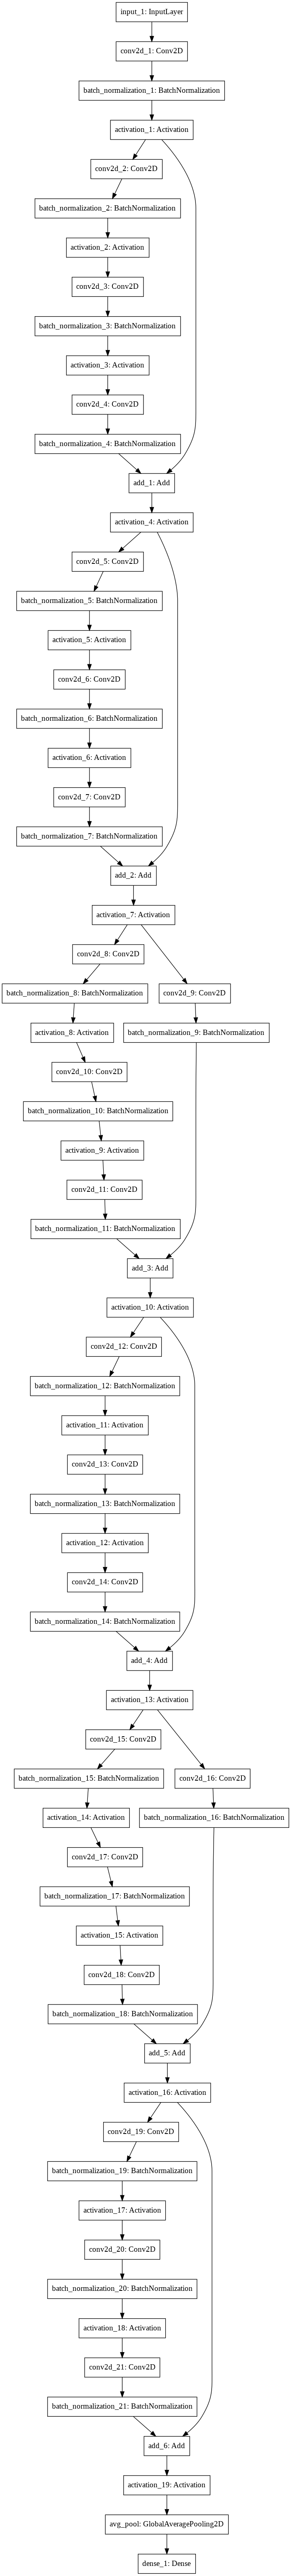

In [0]:
from keras.utils import plot_model
plot_model(model)

In [0]:
model.summary()

Model: "ResNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 16)   64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 16)   0           batch_normalization_1[0][0]      
_____________________________________________________________________________________________

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
modelFilepath =  '/content/drive/My Drive/Colab Notebooks/ResNet/ResNet20.e{epoch:02d}.hdf5'

In [0]:
def lfScheduleF(epoch, lr):
  if epoch > 25:
      return 0.0005
  if epoch > 20:
      return 0.001
  if epoch > 15:
      return 0.005
  if epoch > 10:
      return 0.01
  return 0.1

lrscheduler = LearningRateScheduler(lfScheduleF, verbose=0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., name="ResNet", outputs=Tensor("de...)`


Epoch 1/30
352/352 [==============================] - 38s 108ms/step - loss: 1.7572 - accuracy: 0.4058 - val_loss: 2.7916 - val_accuracy: 0.3140
Epoch 2/30
352/352 [==============================] - 34s 96ms/step - loss: 1.2776 - accuracy: 0.5987 - val_loss: 2.8739 - val_accuracy: 0.4198
Epoch 3/30
352/352 [==============================] - 33s 95ms/step - loss: 1.0543 - accuracy: 0.6842 - val_loss: 3.5859 - val_accuracy: 0.3732
Epoch 4/30
352/352 [==============================] - 34s 95ms/step - loss: 0.9292 - accuracy: 0.7356 - val_loss: 1.1816 - val_accuracy: 0.6574
Epoch 5/30
352/352 [==============================] - 33s 95ms/step - loss: 0.8534 - accuracy: 0.7645 - val_loss: 1.1089 - val_accuracy: 0.6838
Epoch 6/30
352/352 [==============================] - 33s 95ms/step - loss: 0.7996 - accuracy: 0.7818 - val_loss: 1.0099 - val_accuracy: 0.7244
Epoch 7/30
352/352 [==============================] - 33s 95ms/step - loss: 0.7606 - accuracy: 0.7987 - val_loss: 1.1400 - val_accuracy

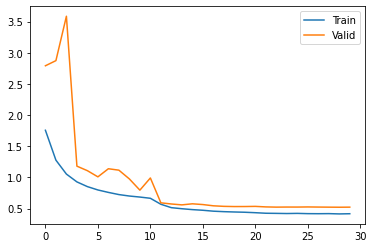

In [0]:
model = ResNet()

datagen = ImageDataGenerator(
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             horizontal_flip=True,
                             )
datagen.fit(x_trainN1)


opt = optimizers.SGD(learning_rate=0.1, momentum=0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit_generator(datagen.flow(x_trainN1, y_trainN1, batch_size=128), epochs=30, validation_data=(x_validN1, y_validN1), callbacks=[lrscheduler])

#history = model.fit(x_trainN1, y_trainN1, epochs = 300, batch_size = 128, validation_data=(x_validN1, y_validN1), callbacks=[lrscheduler])
plot_history(history)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., name="ResNet", outputs=Tensor("de...)`


Epoch 1/30
352/352 [==============================] - 38s 107ms/step - loss: 1.7060 - accuracy: 0.4303 - val_loss: 1.3860 - val_accuracy: 0.5572
Epoch 2/30
352/352 [==============================] - 33s 94ms/step - loss: 1.2597 - accuracy: 0.6057 - val_loss: 1.0932 - val_accuracy: 0.6658
Epoch 3/30
352/352 [==============================] - 33s 94ms/step - loss: 1.0532 - accuracy: 0.6858 - val_loss: 1.0323 - val_accuracy: 0.7020
Epoch 4/30
352/352 [==============================] - 33s 94ms/step - loss: 0.9405 - accuracy: 0.7278 - val_loss: 0.9724 - val_accuracy: 0.7262
Epoch 5/30
352/352 [==============================] - 33s 94ms/step - loss: 0.8634 - accuracy: 0.7583 - val_loss: 0.8597 - val_accuracy: 0.7632
Epoch 6/30
352/352 [==============================] - 33s 94ms/step - loss: 0.8001 - accuracy: 0.7808 - val_loss: 0.8117 - val_accuracy: 0.7794
Epoch 7/30
352/352 [==============================] - 33s 94ms/step - loss: 0.7664 - accuracy: 0.7940 - val_loss: 0.7822 - val_accuracy

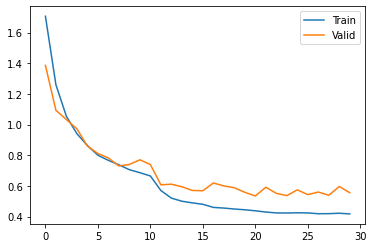

In [0]:
model2 = ResNet(batchnorm_momentum=0.0001)

datagen = ImageDataGenerator(
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             horizontal_flip=True,
                             )
datagen.fit(x_trainN1)


opt = optimizers.SGD(learning_rate=0.1, momentum=0.9)
model2.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

history = model2.fit_generator(datagen.flow(x_trainN1, y_trainN1, batch_size=128), epochs=30, validation_data=(x_validN1, y_validN1), callbacks=[lrscheduler])

#history = model.fit(x_trainN1, y_trainN1, epochs = 300, batch_size = 128, validation_data=(x_validN1, y_validN1), callbacks=[lrscheduler])
plot_history(history)

ResNet - 1: 88%


```
x_trainN1 = x_train - x_train.mean(axis=0)
x_trainN1 = x_trainN1 / np.sqrt((x_trainN1 ** 2).sum(axis=1))[:,None]
```



In [0]:
#import keras.backend as K
#print(K.learning_phase())
model.evaluate(x=x_testN1, y=y_testN1, batch_size=128, verbose=1)

10000/10000 [==============================] - 2s 227us/step


[0.6814195673942566, 0.8816999793052673]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., name="ResNet", outputs=Tensor("de...)`
  from ipykernel import kernelapp as app


Train on 45000 samples, validate on 5000 samples
Epoch 1/50
45000/45000 [==============================] - 32s 722us/step - loss: 2.0051 - accuracy: 0.2438 - val_loss: 7.6963 - val_accuracy: 0.1328
Epoch 2/50
45000/45000 [==============================] - 21s 474us/step - loss: 1.6214 - accuracy: 0.3811 - val_loss: 7.2932 - val_accuracy: 0.2158
Epoch 3/50
45000/45000 [==============================] - 21s 474us/step - loss: 1.4113 - accuracy: 0.4782 - val_loss: 4.2786 - val_accuracy: 0.3086
Epoch 4/50
45000/45000 [==============================] - 21s 471us/step - loss: 1.2499 - accuracy: 0.5466 - val_loss: 1.5173 - val_accuracy: 0.4890
Epoch 5/50
45000/45000 [==============================] - 21s 472us/step - loss: 1.1193 - accuracy: 0.5956 - val_loss: 1.5554 - val_accuracy: 0.5082
Epoch 6/50
45000/45000 [==============================] - 21s 471us/step - loss: 1.0135 - accuracy: 0.6352 - val_loss: 1.1658 - val_accuracy: 0.5908
Epoch 7/50
45000/45000 [==============================] -

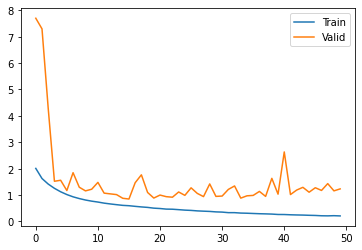

Train on 45000 samples, validate on 5000 samples
Epoch 1/50
45000/45000 [==============================] - 23s 503us/step - loss: 1.5773 - accuracy: 0.4144 - val_loss: 1.4777 - val_accuracy: 0.4522
Epoch 2/50
45000/45000 [==============================] - 19s 416us/step - loss: 1.1986 - accuracy: 0.5639 - val_loss: 1.6040 - val_accuracy: 0.4560
Epoch 3/50
45000/45000 [==============================] - 19s 415us/step - loss: 1.0019 - accuracy: 0.6411 - val_loss: 1.2348 - val_accuracy: 0.5664
Epoch 4/50
45000/45000 [==============================] - 19s 419us/step - loss: 0.8717 - accuracy: 0.6889 - val_loss: 1.7505 - val_accuracy: 0.4922
Epoch 5/50
45000/45000 [==============================] - 19s 414us/step - loss: 0.7778 - accuracy: 0.7233 - val_loss: 1.0295 - val_accuracy: 0.6328
Epoch 6/50
45000/45000 [==============================] - 19s 417us/step - loss: 0.6911 - accuracy: 0.7550 - val_loss: 1.2564 - val_accuracy: 0.5900
Epoch 7/50
45000/45000 [==============================] -

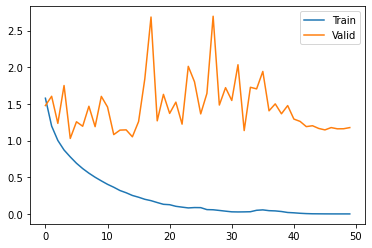

Train on 45000 samples, validate on 5000 samples
Epoch 1/50
45000/45000 [==============================] - 27s 592us/step - loss: 1.7606 - accuracy: 0.3443 - val_loss: 8.8759 - val_accuracy: 0.1208
Epoch 2/50
45000/45000 [==============================] - 22s 481us/step - loss: 1.3088 - accuracy: 0.5208 - val_loss: 2.7483 - val_accuracy: 0.3230
Epoch 3/50
45000/45000 [==============================] - 21s 476us/step - loss: 1.0567 - accuracy: 0.6218 - val_loss: 3.7805 - val_accuracy: 0.3190
Epoch 4/50
45000/45000 [==============================] - 21s 476us/step - loss: 0.9232 - accuracy: 0.6714 - val_loss: 4.2108 - val_accuracy: 0.3382
Epoch 5/50
45000/45000 [==============================] - 21s 474us/step - loss: 0.8286 - accuracy: 0.7071 - val_loss: 1.4696 - val_accuracy: 0.5824
Epoch 6/50
45000/45000 [==============================] - 22s 483us/step - loss: 0.7484 - accuracy: 0.7374 - val_loss: 1.0011 - val_accuracy: 0.6598
Epoch 7/50
45000/45000 [==============================] -

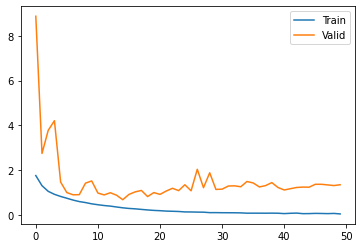

Train on 45000 samples, validate on 5000 samples
Epoch 1/50
45000/45000 [==============================] - 30s 671us/step - loss: 1.6902 - accuracy: 0.3706 - val_loss: 1.6875 - val_accuracy: 0.3794
Epoch 2/50
45000/45000 [==============================] - 19s 431us/step - loss: 1.3230 - accuracy: 0.5171 - val_loss: 1.3597 - val_accuracy: 0.5048
Epoch 3/50
45000/45000 [==============================] - 19s 431us/step - loss: 1.1500 - accuracy: 0.5858 - val_loss: 1.6023 - val_accuracy: 0.4878
Epoch 4/50
45000/45000 [==============================] - 19s 430us/step - loss: 1.0305 - accuracy: 0.6314 - val_loss: 1.1997 - val_accuracy: 0.5632
Epoch 5/50
25344/45000 [===============>..............] - ETA: 8s - loss: 0.9517 - accuracy: 0.6622

KeyboardInterrupt: ignored

In [0]:
for lr in [0.1, 0.05, 0.01, 0.005, 0.001]:
  model = ResNet()
  opt = optimizers.Adam(learning_rate=lr)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  history = model.fit(x_trainN1, y_trainN1, epochs = 50, batch_size = 128, validation_data=(x_validN1, y_validN1))
  plot_history(history)
  
  model = ResNet()
  opt = optimizers.SGD(learning_rate=lr)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  history = model.fit(x_trainN1, y_trainN1, epochs = 50, batch_size = 128, validation_data=(x_validN1, y_validN1))
  plot_history(history)


In [0]:
checkpointer = ModelCheckpoint(filepath, verbose=1, save_best_only=True)
history = model.fit(x_trainN1, y_trainN1, epochs = 300, batch_size = 128, validation_data=(x_validN1, y_validN1), callbacks=[checkpointer])

Train on 45000 samples, validate on 5000 samples
Epoch 1/300
45000/45000 [==============================] - 68s 2ms/step - loss: 1.6644 - accuracy: 0.4005 - val_loss: 3.0325 - val_accuracy: 0.2120
Epoch 2/300
45000/45000 [==============================] - 56s 1ms/step - loss: 1.2276 - accuracy: 0.5583 - val_loss: 1.3820 - val_accuracy: 0.5158
Epoch 3/300
45000/45000 [==============================] - 56s 1ms/step - loss: 0.9817 - accuracy: 0.6511 - val_loss: 1.0501 - val_accuracy: 0.6236
Epoch 4/300
45000/45000 [==============================] - 56s 1ms/step - loss: 0.8196 - accuracy: 0.7111 - val_loss: 0.9615 - val_accuracy: 0.6730
Epoch 5/300
45000/45000 [==============================] - 56s 1ms/step - loss: 0.6840 - accuracy: 0.7600 - val_loss: 0.9463 - val_accuracy: 0.6962
Epoch 6/300
45000/45000 [==============================] - 56s 1ms/step - loss: 0.5838 - accuracy: 0.7954 - val_loss: 0.9843 - val_accuracy: 0.6864
Epoch 7/300
45000/45000 [==============================] - 56s 

KeyboardInterrupt: ignored

In [0]:
plot_history(history)

In [0]:
imgen  = ImageDataGenerator(featurewise_center=True,
                            featurewise_std_normalization=True,
                            horizontal_flip=True)